# Osteocyte Network Analysis: Segmentation Comparison

This notebook implements an initial pipeline for analyzing osteocyte cell culture videos, as part of the MSc project *Characterisation and Physics-Based Modelling of Osteocyte Network Formation*. The focus is to compare region-based and edge-based segmentation methods to identify the most effective approach for segmenting osteocyte cells in 2D video data, per the scikit-image segmentation tutorial (https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html).

## Objectives
- Read and preprocess video frames using OpenCV (`cv2`) with enhanced contrast and noise reduction.
- Compare four segmentation methods:
  1. **Otsu’s Thresholding (Region-Based)**: Global thresholding to separate cells from background.
  2. **Random Walker (Region-Based)**: Probabilistic segmentation for noisy or complex images.
  3. **Canny + Watershed (Edge-Based)**: Uses Canny edge detection and Watershed to separate cells.
  4. **Sobel + Watershed (Hybrid)**: Combines Sobel edge detection with region-based markers.
- Compute morphological descriptors (area, circularity, perimeter, centroid) for segmented cells.
- Track cell movements using Trackpy across a subset of frames.
- Visualize results with Matplotlib (static) and Napari (interactive).
- Evaluate methods using cell count, average area, circularity, and visual quality.

## Prerequisites
- Install libraries: `pip install opencv-python scikit-image trackpy matplotlib napari pandas scipy`.
- Make sure the video file (e.g., `wildtype/MLO-Y4 WT DMSO/Confluence_Single movie_30.03.2025_no mask_C2_3.mp4`) is in the working directory or adjust the path.
- Python 3.11 is used. Ensure scikit-image ≥0.19.0 for correct module imports.

In [126]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.filters import threshold_otsu, sobel, gaussian, median
from skimage.feature import canny
from skimage.morphology import binary_closing, binary_opening, disk
from skimage.measure import label, regionprops
from skimage.segmentation import watershed, random_walker
from skimage.exposure import equalize_hist, rescale_intensity
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
import trackpy as tp
import pandas as pd
import napari
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## Step 1: Read and Preprocess Video Frames

Load the video using OpenCV, convert frames to grayscale, apply histogram equalization for contrast enhancement, and Gaussian blur for noise reduction. Crop the bottom portion to remove overlays. Frames are stored for segmentation and tracking.

Loaded 48 frames.


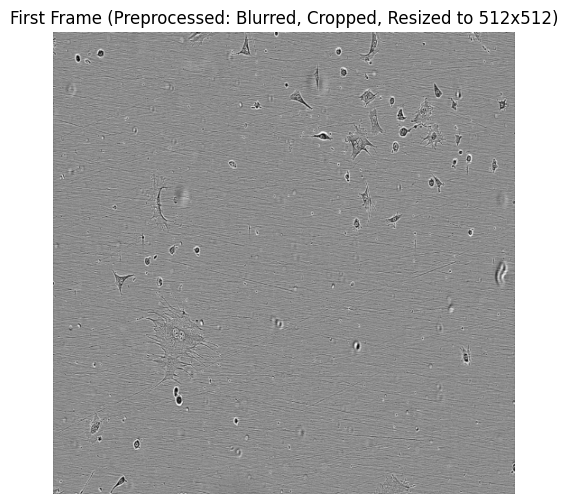

In [127]:
from skimage.transform import resize
# Path to the video file
video_path = '/Users/diana/Desktop/Osteocytes-Summer-Project-2025/2d-cell-cultures/Osteocytes culture/wildtype/MLO-Y4 WT DMSO/Confluence_Single movie_30.03.2025_no mask_C2_3.mp4'

# Open the video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError(f'Video file {video_path} not found. Please check the file path.')
if cap.get(cv2.CAP_PROP_FRAME_COUNT) == 0:
    raise ValueError(f'No frames detected in {video_path}. Check video integrity.')

# Read and process video frames
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply minimal Gaussian blur
    frame = gaussian(frame, sigma=0.5)  # Reduced blur to preserve details
    # Crop bottom portion (adjust based on video resolution, e.g., 860 rows)
    frame = frame[:860, :]
    if frame.size == 0:
        print('Warning: Cropped frame is empty. Adjust crop dimensions.')
        break
    # Resize to 512x512 for CPN compatibility
    frame = resize(frame, (512, 512), mode='constant', anti_aliasing=True)
    frames.append(frame)

cap.release()
if len(frames) == 0:
    raise ValueError('No frames processed. Check video or preprocessing steps.')
print(f'Loaded {len(frames)} frames.')

# Display first frame
plt.figure(figsize=(8, 6))
plt.imshow(frames[0], cmap='gray')
plt.title('First Frame (Preprocessed: Blurred, Cropped, Resized to 512x512)')
plt.axis('off')
plt.show()

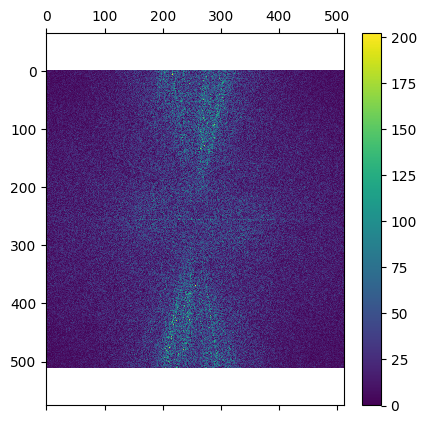

In [128]:
# tentative Fourier look at the data
# Prepare the frame

frame = frames[0].astype(float) # convert to float
img = frame -frame.mean() # substract the avg pixel value to centre the image data

# Compute the Fourier Transform
FFT = np.fft.fft2(img) # Fast Fourier Transform
FFT_shifted = np.fft.fftshift(FFT)  #bring the zero frequency at the centre of Fourier image
PS = np.absolute(FFT) # power spectrum
PS_shifted = np.fft.fftshift(PS)  #bring the zero frequency at the centre of Fourier image
plt.matshow(PS_shifted)
plt.axis("equal")
plt.colorbar()

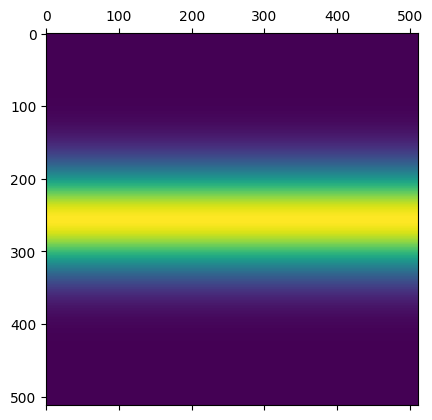

In [129]:
# Create an elliptical mask
shape = img.shape # get the frame's dimentions
rows, cols = np.indices(shape) # coordinates for each pixel 
# Define a mask
mask_radius = 250
semi_axis_major = 850
semi_axis_minor = 10
mask = ((rows-shape[0]//2)**2/semi_axis_minor**2+(cols-shape[1]//2)**2/semi_axis_major**2)< 1
mask = gaussian(mask, 50) # smooth the mask with gaussian blur
plt.matshow(mask) # show the mask as image

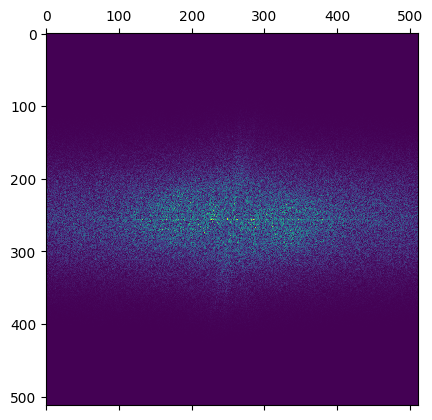

In [130]:
# Apply mask and visualize
masked_FFT = mask*FFT_shifted # keep only the ellipse frequencies
plt.matshow(np.abs(masked_FFT)) # display the masked spectrum's magnitude

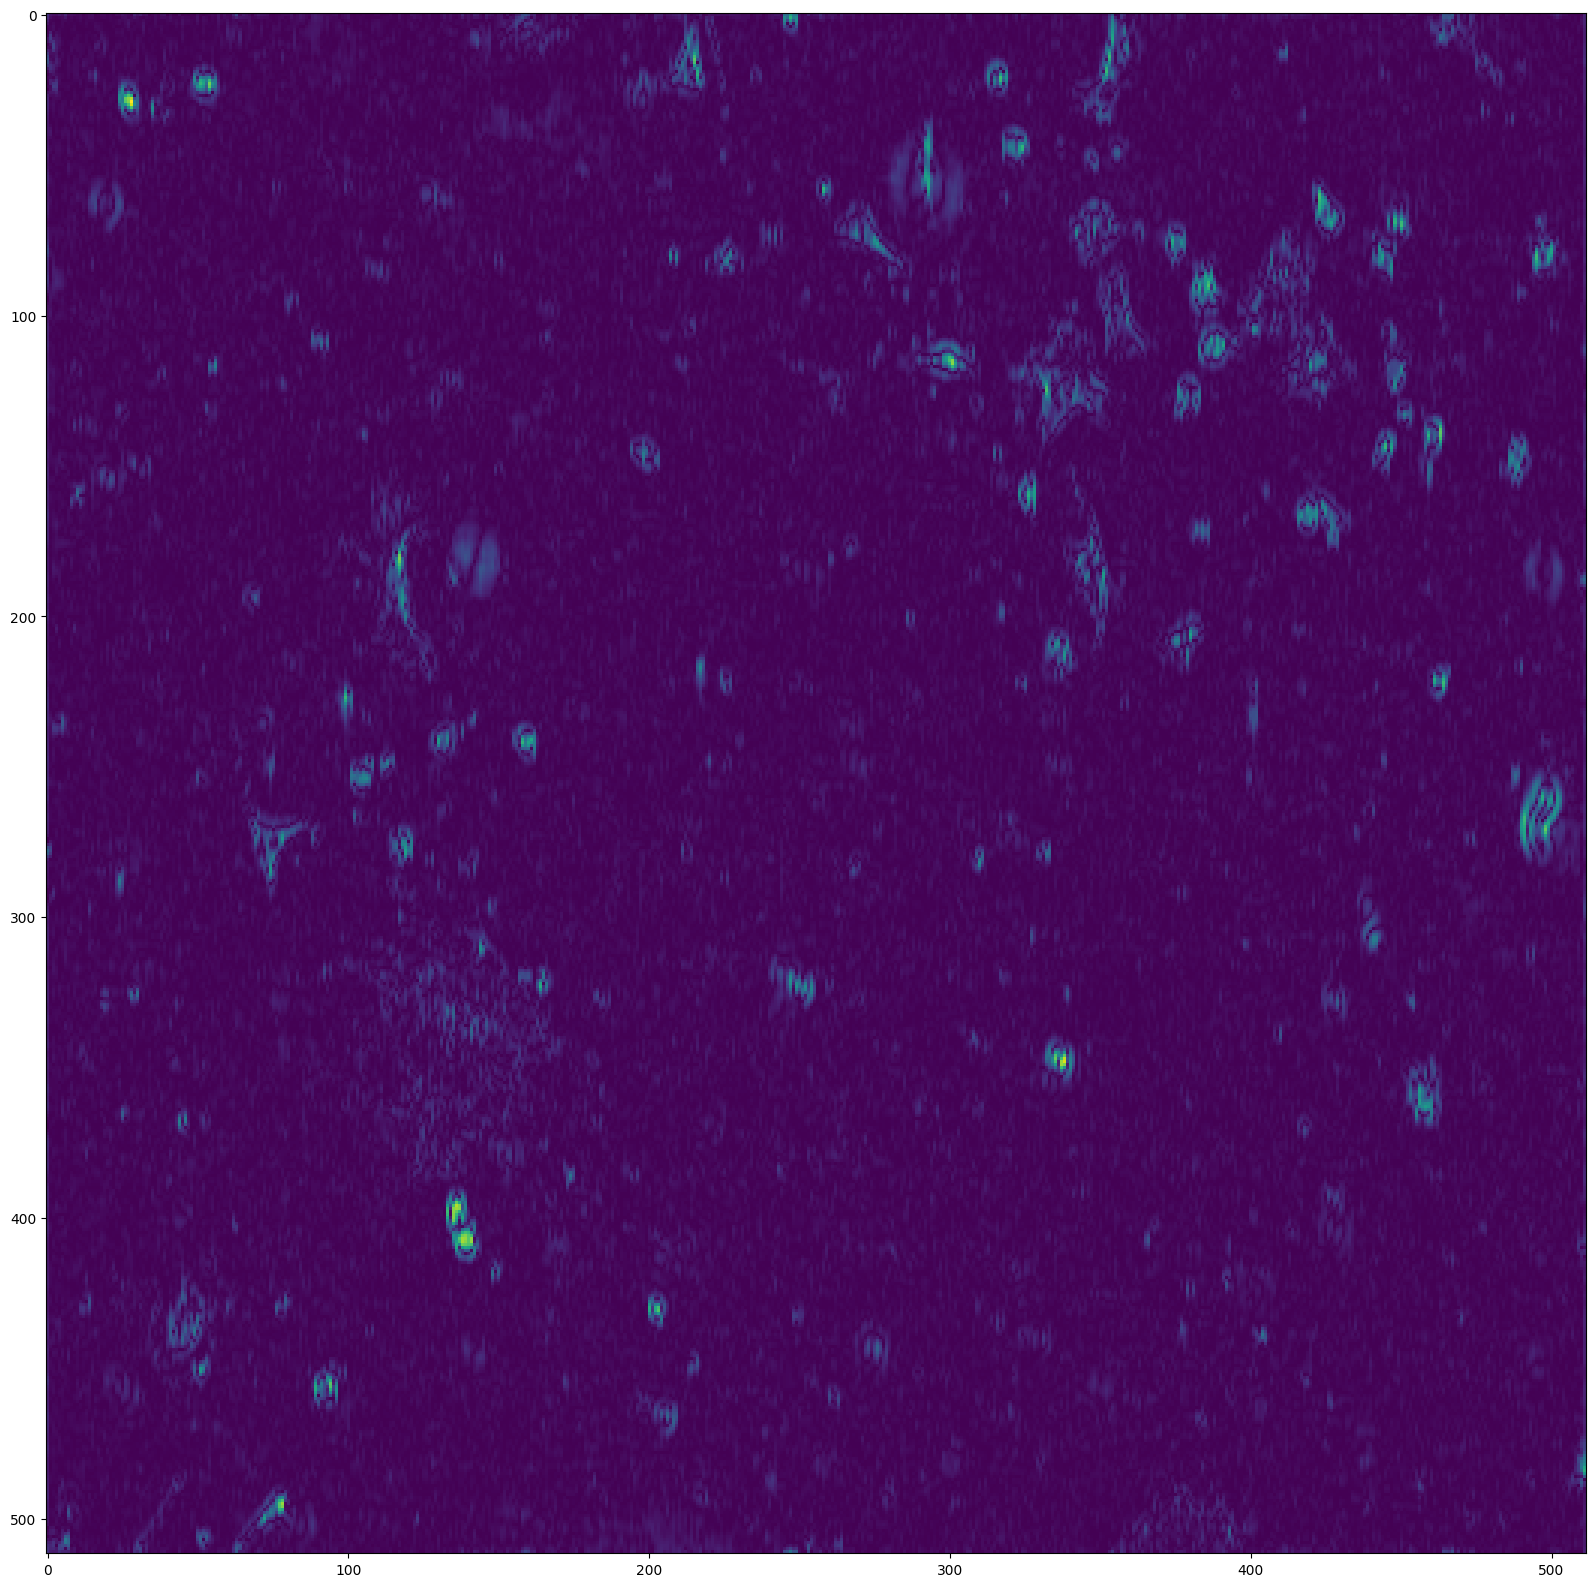

In [131]:
# Attempt image reconstruction
iFFT = np.fft.ifft2(masked_FFT) # an inverse Fourier Transform
plt.figure(figsize=(20,20)) 
plt.imshow(np.abs(iFFT)) # shows the reconstructed image's magnitude 

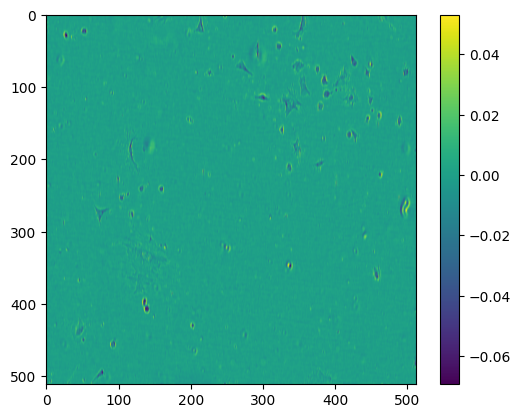

In [132]:
# Apply the elliptical mask 
product = FFT_shifted* mask
# Shift frequencies back to inverse FFT
reverse_shifted_product = np.fft.ifftshift(product)
# Reconstruct the image taking the real part
recovered_image = np.fft.ifft2(reverse_shifted_product).real
# Show the result
plt.imshow(recovered_image)
plt.colorbar()

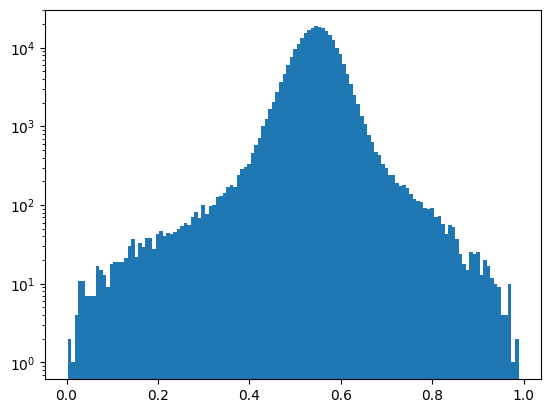

In [133]:
# Plot a histogram
plt.hist(frame.ravel(), 128);
plt.yscale('log')

In [134]:
# Test FFT with Parabolic Mask
# Create a parabolic mask
shape = img.shape
rows, cols = np.indices(shape)

# Initialize mask
mask = np.zeros(shape)

# Define parabolic parameters
center_row = shape[0] // 2
parabola_width = 150  # Controls the width of the parabolic opening
parabola_height = 30  # Controls how steep the parabola is

# Compute column indices relative to center
col_indices = cols[0, :] - shape[1] // 2

# Create top parabola (opens downward): rows = center_row + a * (cols / b)^2
top_parabola = center_row + parabola_height * (col_indices / parabola_width) ** 2
# Create bottom parabola (opens upward): rows = center_row - a * (cols / b)^2
bottom_parabola = center_row - parabola_height * (col_indices / parabola_width) ** 2

# Vectorized mask creation
# For each pixel (r, c), check if row r is between bottom_parabola[c] and top_parabola[c]
for c in range(shape[1]):
    mask[:, c] = (rows[:, c] >= bottom_parabola[c]) & (rows[:, c] <= top_parabola[c])

# Smooth the mask with Gaussian blur
mask = gaussian(mask, sigma=100)

<Figure size 800x600 with 0 Axes>

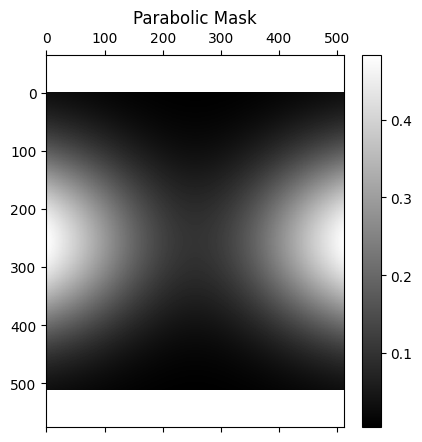

In [135]:
# Visualize the mask
plt.figure(figsize=(8, 6))
plt.matshow(mask, cmap='gray')
plt.title('Parabolic Mask')
plt.axis('equal')
plt.colorbar()
plt.show()

<Figure size 800x600 with 0 Axes>

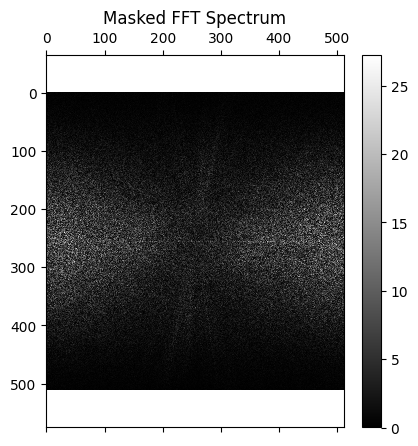

In [136]:
# Apply mask and visualize
masked_FFT = mask * FFT_shifted
plt.figure(figsize=(8, 6))
plt.matshow(np.abs(masked_FFT), cmap='gray')
plt.title('Masked FFT Spectrum')
plt.axis('equal')
plt.colorbar()
plt.show()

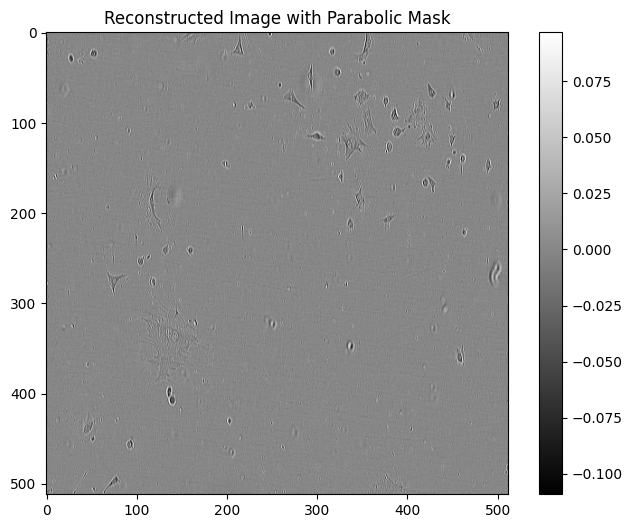

In [137]:
# Reconstruct the image
product = FFT_shifted * mask
reverse_shifted_product = np.fft.ifftshift(product)
recovered_image = np.fft.ifft2(reverse_shifted_product).real

# Show the reconstructed image
plt.figure(figsize=(8, 6))
plt.imshow(recovered_image, cmap='gray')
plt.title('Reconstructed Image with Parabolic Mask')
plt.colorbar()
plt.show()

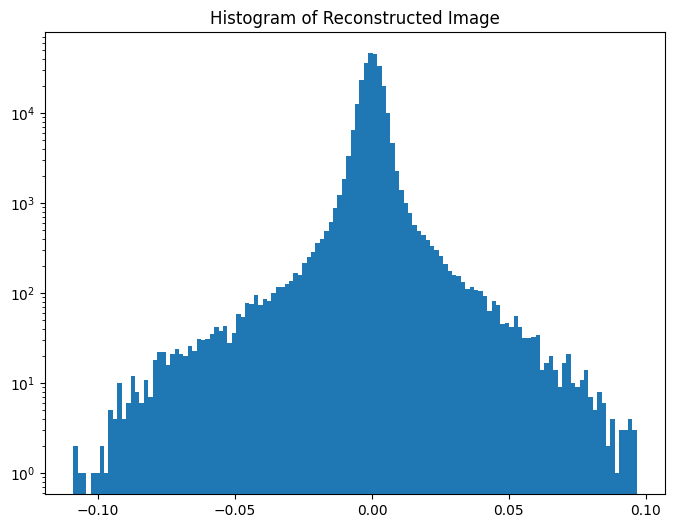

In [138]:
# Show histogram of the reconstructed image
plt.figure(figsize=(8, 6))
plt.hist(recovered_image.ravel(), bins=128)
plt.yscale('log')
plt.title('Histogram of Reconstructed Image')
plt.show()

In [139]:
# Cell Counting
image = recovered_image
image = rescale_intensity(image, in_range='image', out_range=(0, 1))
image = gaussian(image, sigma=0.5)
inverted_image = 1 - image

# Adaptive thresholding
try:
    thresh = threshold_local(inverted_image, block_size=51, offset=0.03)  # Softer threshold
    binary = inverted_image > thresh
except ValueError:
    binary = inverted_image > 0.25  # Manual fallback
binary_raw = binary.copy()

# Morphological cleanup
selem = disk(2)  # Lighter to preserve cells
binary = binary_opening(binary, selem)
binary = binary_closing(binary, selem)

# Watershed
binary_smooth = gaussian(binary.astype(float), sigma=1)  # Lighter smoothing
distance = distance_transform_edt(binary)
local_maxi = peak_local_max(distance, min_distance=2, labels=binary, threshold_rel=0.1)  # More markers, filter weak maxima
markers = np.zeros(distance.shape, dtype=np.int32)
if local_maxi.size > 0:
    markers[local_maxi[:, 0], local_maxi[:, 1]] = np.arange(1, len(local_maxi) + 1)
    labels = watershed(-distance, markers, mask=binary)
else:
    labels = label(binary)

# Count cells
min_area = 100  # Include smaller cells
max_area = 500  # Exclude merged regions
labeled_cells = labels
regions = regionprops(labeled_cells)
regions = [r for r in regions if min_area <= r.area <= max_area]
num_cells = len(regions)
print(f"Detected {num_cells} cells")

Detected 66 cells


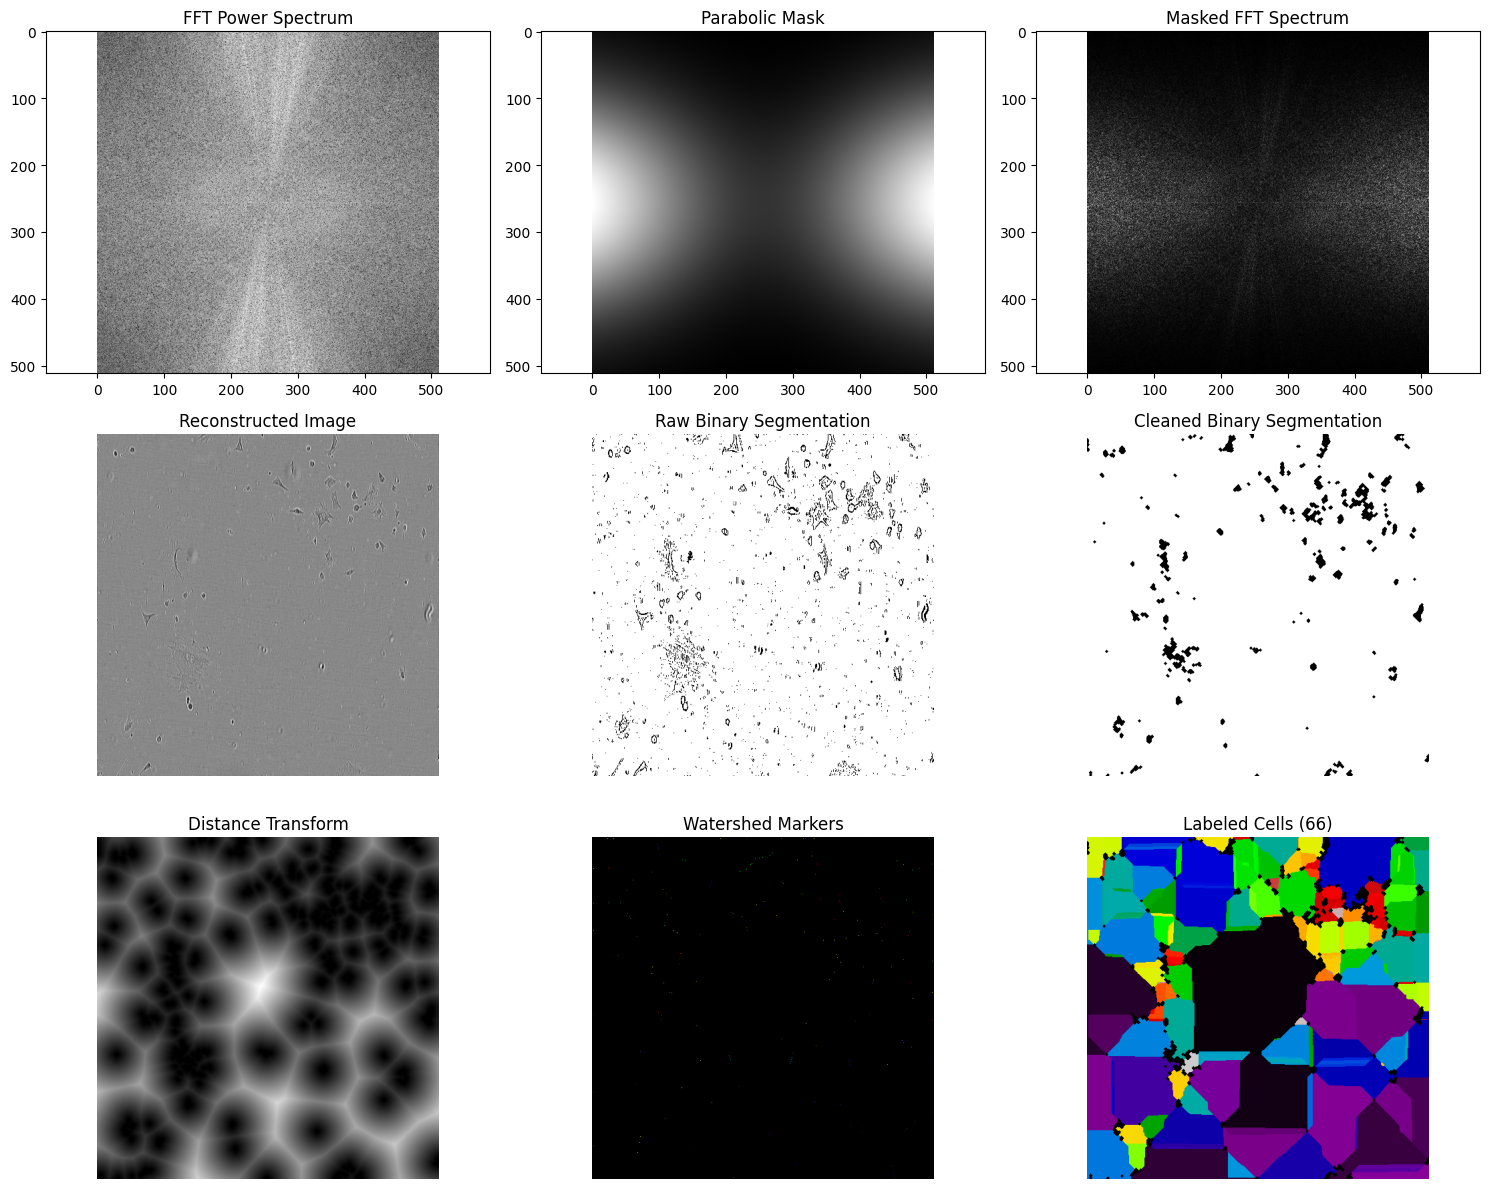

In [140]:
# Visualizations
plt.figure(figsize=(15, 12))

# FFT Power Spectrum
plt.subplot(3, 3, 1)
plt.imshow(np.log(PS_shifted + 1), cmap='gray')
plt.title('FFT Power Spectrum')
plt.axis('equal')

# Parabolic Mask
plt.subplot(3, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Parabolic Mask')
plt.axis('equal')

# Masked FFT
plt.subplot(3, 3, 3)
plt.imshow(np.abs(masked_FFT), cmap='gray')
plt.title('Masked FFT Spectrum')
plt.axis('equal')

# Reconstructed Image
plt.subplot(3, 3, 4)
plt.imshow(image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

# Raw Binary
plt.subplot(3, 3, 5)
plt.imshow(binary_raw, cmap='gray')
plt.title('Raw Binary Segmentation')
plt.axis('off')

# Cleaned Binary
plt.subplot(3, 3, 6)
plt.imshow(binary, cmap='gray')
plt.title('Cleaned Binary Segmentation')
plt.axis('off')

# Distance Transform
plt.subplot(3, 3, 7)
plt.imshow(distance, cmap='gray')
plt.title('Distance Transform')
plt.axis('off')

# Watershed Markers
plt.subplot(3, 3, 8)
plt.imshow(markers, cmap='nipy_spectral')
plt.title('Watershed Markers')
plt.axis('off')

# Labeled Cells
plt.subplot(3, 3, 9)
plt.imshow(labeled_cells, cmap='nipy_spectral')
plt.title(f'Labeled Cells ({num_cells})')
plt.axis('off')

plt.tight_layout()
plt.show()

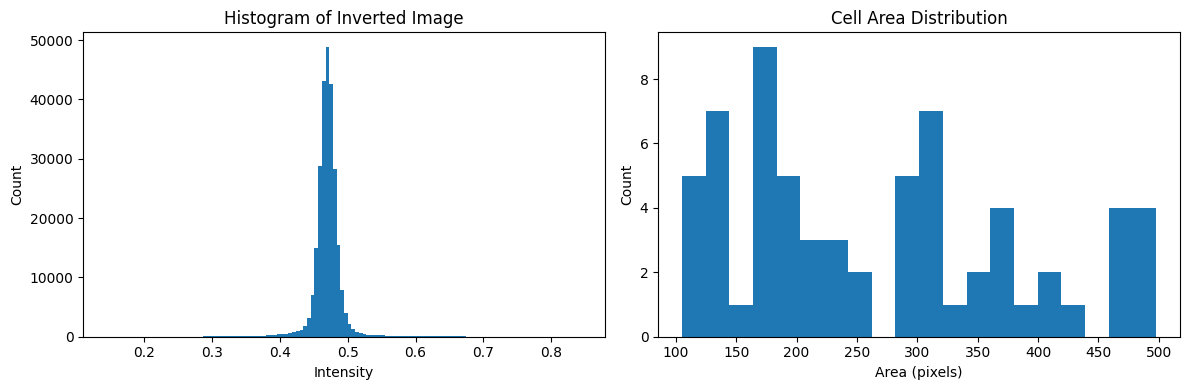

Cell areas (pixels): [486.0, 496.0, 199.0, 329.0, 305.0, 305.0, 297.0, 297.0, 400.0, 371.0, 319.0, 110.0, 475.0, 169.0, 167.0, 134.0, 257.0, 113.0, 169.0, 172.0, 198.0, 217.0, 109.0, 105.0, 358.0, 469.0, 192.0, 143.0, 170.0, 170.0, 130.0, 174.0, 196.0, 303.0, 303.0, 493.0, 156.0, 131.0, 373.0, 223.0, 174.0, 113.0, 438.0, 468.0, 358.0, 370.0, 287.0, 384.0, 310.0, 245.0, 233.0, 230.0, 498.0, 297.0, 130.0, 215.0, 139.0, 308.0, 415.0, 214.0, 289.0, 376.0, 178.0, 201.0, 139.0, 470.0]
Average cell area: 267.61 pixels


In [141]:
# Histograms
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(inverted_image.ravel(), bins=128)
plt.title('Histogram of Inverted Image')
plt.xlabel('Intensity')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist([r.area for r in regions], bins=20)
plt.title('Cell Area Distribution')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print cell areas
areas = [region.area for region in regions]
print(f"Cell areas (pixels): {areas}")
if areas:
    print(f"Average cell area: {np.mean(areas):.2f} pixels")
else:
    print("No cells detected with area >= min_area.")

In [142]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Step 2: Compare Segmentation Methods

Test four segmentation methods on the first frame, including region-based (Otsu’s, Random Walker) and edge-based (Canny + Watershed, Sobel + Watershed), per the scikit-image tutorial (https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html). Each method’s output is labeled, cleaned, and evaluated quantitatively (cell count, area, circularity) and visually.

Using device: cpu


/var/folders/kk/msr9gncd53l2vwhdqjy18xyr0000gn/T/ipykernel_15667/606489137.py:59: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labeled_otsu = morphology.remove_small_objects(labeled_otsu, min_size=200)


Segmentation Validation:
Otsu’s Thresholding Results:
Number of cells: 1
Average area: 262144.00 pixels
Standard deviation of area: nan pixels
Average circularity: 0.79
Standard deviation of circularity: nan
Random Walker Results:
Number of cells: 2
Average area: 131072.00 pixels
Standard deviation of area: 178722.65 pixels
Average circularity: 0.02
Standard deviation of circularity: 0.02


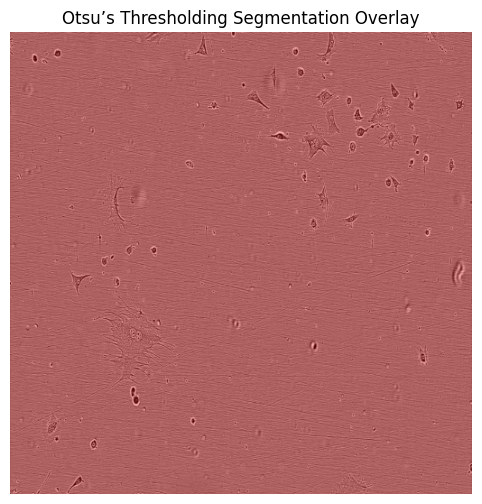

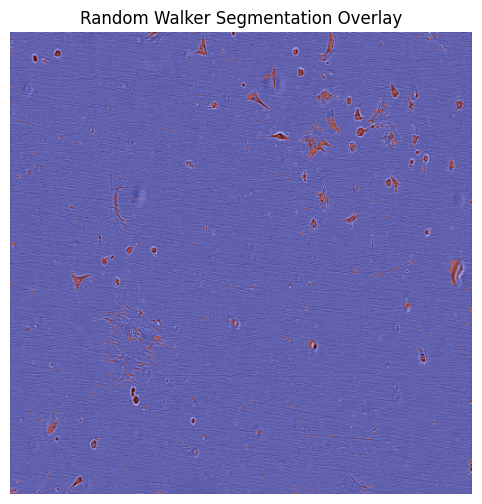

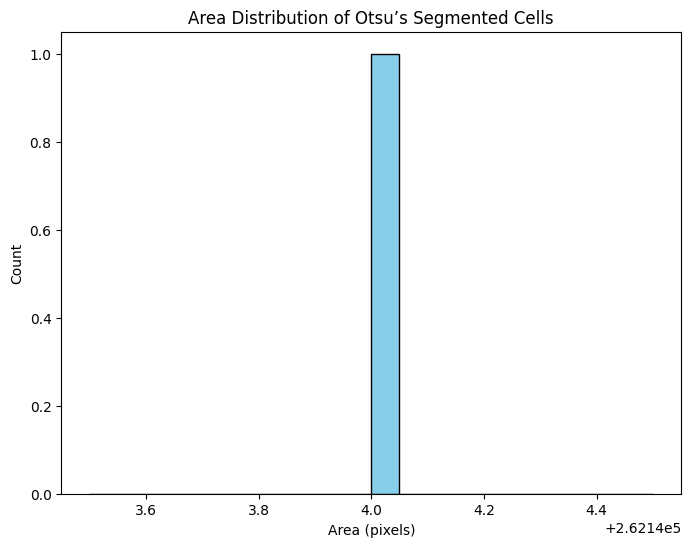

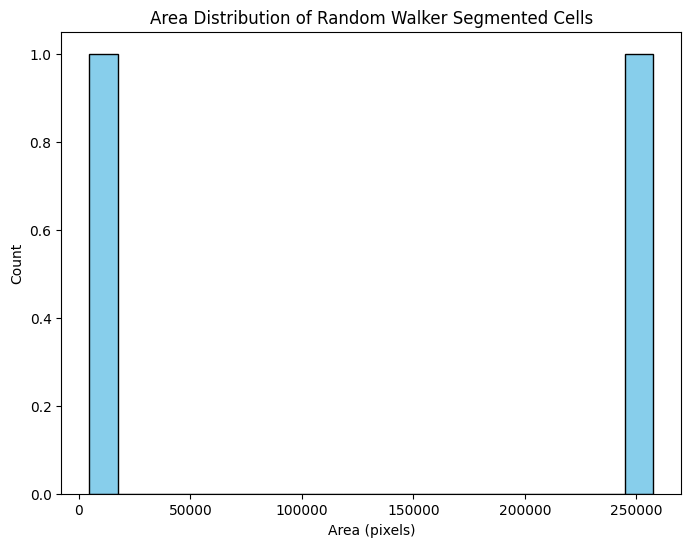

In [ ]:
# Step 2: Cell Detection and Segmentation Comparison
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
import torch
import celldetection as cd
from skimage.color import label2rgb
import pandas as pd
from skimage.color import gray2rgb
%matplotlib inline

# Function to compute morphological descriptors
def compute_morphological_descriptors(labeled):
    props = measure.regionprops(labeled)
    morph_data = {
        'cell_id': [],
        'area': [],
        'perimeter': [],
        'circularity': [],
        'centroid_x': [],
        'centroid_y': []
    }
    for region in props:
        area = region.area
        perimeter = region.perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        centroid = region.centroid
        morph_data['cell_id'].append(region.label)
        morph_data['area'].append(area)
        morph_data['perimeter'].append(perimeter)
        morph_data['circularity'].append(circularity)
        morph_data['centroid_x'].append(centroid[1])
        morph_data['centroid_y'].append(centroid[0])
    return pd.DataFrame(morph_data)

# Load pre-trained CPN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
model = cd.fetch_model('ginoro_CpnResNeXt101UNet-fbe875f1a3e5ce2c', check_hash=True).to(device)
model.eval()

# Prepare first frame
frame = frames[0]
rgb_frame = gray2rgb(frame)
if rgb_frame.size == 0:
    raise ValueError('RGB conversion failed. Check frame data.')

# Normalize to [0.0, 1.0] as required by the model
x = cd.to_tensor(rgb_frame, transpose=True, device=device, dtype=torch.float32)
x = x / 255.0
x = x[None]


# 2.1: Otsu’s Thresholding (Region-Based)
thresh_otsu = threshold_otsu(frame)
binary_otsu = frame > thresh_otsu
binary_otsu = binary_closing(binary_otsu, disk(5))
binary_otsu = binary_opening(binary_otsu, disk(5))
labeled_otsu = measure.label(binary_otsu, connectivity=2)
labeled_otsu = morphology.remove_small_objects(labeled_otsu, min_size=200)

# 2.2: Random Walker (Region-Based)
markers_rw = np.zeros_like(frame, dtype=np.int32)
markers_rw[frame < thresh_otsu * 0.7] = 1  # Background
markers_rw[frame > thresh_otsu * 1.2] = 2  # Foreground
labeled_random_walker = random_walker(frame, markers_rw, beta=50, mode='bf')
labeled_random_walker = morphology.remove_small_objects(labeled_random_walker, min_size=200)

morph_df_otsu = compute_morphological_descriptors(labeled_otsu)
morph_df_random_walker = compute_morphological_descriptors(labeled_random_walker)

# Validation checks
print('Segmentation Validation:')

print('Otsu’s Thresholding Results:')
print(f'Number of cells: {len(morph_df_otsu)}')
print(f'Average area: {morph_df_otsu["area"].mean():.2f} pixels')
print(f'Standard deviation of area: {morph_df_otsu["area"].std():.2f} pixels')
print(f'Average circularity: {morph_df_otsu["circularity"].mean():.2f}')
print(f'Standard deviation of circularity: {morph_df_otsu["circularity"].std():.2f}')
print('Random Walker Results:')
print(f'Number of cells: {len(morph_df_random_walker)}')
print(f'Average area: {morph_df_random_walker["area"].mean():.2f} pixels')
print(f'Standard deviation of area: {morph_df_random_walker["area"].std():.2f} pixels')
print(f'Average circularity: {morph_df_random_walker["circularity"].mean():.2f}')
print(f'Standard deviation of circularity: {morph_df_random_walker["circularity"].std():.2f}')

# Common validation checks

morph_df = morph_df_random_walker  # Default to Random walker for validation

# Cell count check (expect 20–100 for osteocyte culture)
if len(morph_df) < 20:
    print('Warning: Low cell count. Adjust preprocessing or parameters.')
elif len(morph_df) > 100:
    print('Warning: High cell count. Check for over-segmentation or noise.')
# Area check (~100–10,000 pixels)
if morph_df['area'].mean() < 100 or morph_df['area'].mean() > 10000:
    print('Warning: Average area outside expected range. Review image scale or model.')
elif morph_df['area'].std() > morph_df['area'].mean() * 0.5:
    print('Warning: High area variance. Check for inconsistent region sizes.')
# Circularity check (0.3–0.8)
if morph_df['circularity'].mean() < 0.3 or morph_df['circularity'].mean() > 0.8:
    print('Warning: Circularity outside expected range. Check for irregular regions.')
elif morph_df['circularity'].std() > 0.3:
    print('Warning: High circularity variance. Check for fragmented or noisy regions.')

# Visualize segmentation overlays
overlay_otsu = label2rgb(labeled_otsu, image=frame, bg_label=0)
plt.figure(figsize=(8, 6))
plt.imshow(overlay_otsu)
plt.title('Otsu’s Thresholding Segmentation Overlay')
plt.axis('off')
plt.show()
overlay_random_walker = label2rgb(labeled_random_walker, image=frame, bg_label=0)
plt.figure(figsize=(8, 6))
plt.imshow(overlay_random_walker)
plt.title('Random Walker Segmentation Overlay')
plt.axis('off')
plt.show()

# Visualize area distributions
plt.figure(figsize=(8, 6))
plt.hist(morph_df_otsu['area'], bins=20, color='skyblue', edgecolor='black')
plt.title('Area Distribution of Otsu’s Segmented Cells')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(morph_df_random_walker['area'], bins=20, color='skyblue', edgecolor='black')
plt.title('Area Distribution of Random Walker Segmented Cells')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.show()

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:
# Function to compute morphological descriptors
def compute_morphological_descriptors(labeled): # function takes a labeled image as input 
                                                # where each cell is assigned a number
    props = measure.regionprops(labeled) # find all labeled regions (cells) and get their properties
    morph_data = { # dict. with measurements for each cell
        'cell_id': [], # cell label
        'area': [], # size of the cell in pixels
        'perimeter': [], # length of the cell's outline
        'circularity': [], # how round the cell is (1 - perfect circle, lower - less round)
        'centroid_x': [], # x coordinate of the cell centre
        'centroid_y': [] # y coordinate of the cell centre
    }
    # Go through each cell, calculate its features and store them in a dict
    for region in props: # loop over each cell
        area = region.area # get cell's size (number of pixels inside)
        perimeter = region.perimeter # get the length of the cell's outline
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0 # calculate how round the cell is
        centroid = region.centroid # get the centre point coordinates
        # Append each measure to the dict
        morph_data['cell_id'].append(region.label)
        morph_data['area'].append(area)
        morph_data['perimeter'].append(perimeter)
        morph_data['circularity'].append(circularity)
        morph_data['centroid_x'].append(centroid[1])
        morph_data['centroid_y'].append(centroid[0])
    # Convert each dict into a table using Pandas
    return pd.DataFrame(morph_data)

# First frame for segmentation
# Convert the frame's pixel values to floating-point numbers required for some segmentation methods
frame = frames[0].astype(float)  # Already normalized by equalize_hist

In [ ]:
# 2.1: Otsu’s Thresholding (Region-Based)
# Otsu’s is a simple way to find cells by brightness, serving as a baseline to compare with other methods.
thresh_otsu = threshold_otsu(frame) # find a brightness value that best separates dark (background) and light (cells)
binary_otsu = (frame < thresh_otsu*0.9) # b&w image where pixels brighter than threshold are white (cells) and others are black (background)
# binary_otsu = binary_closing(binary_otsu, disk(3)) # fill small holes in the white areas to make them smoother
# binary_otsu = binary_opening(binary_otsu, disk(3)) # remove noise to clean up the image

labeled_otsu = measure.label(binary_otsu, connectivity=2) # assign a unique number to each connected white region (cell)
labeled_otsu = morphology.remove_small_objects(labeled_otsu, min_size=100) # remove tiny regions <100 pixels (noise)
morph_otsu = compute_morphological_descriptors(labeled_otsu) # measure morphological descriptors using the function

# 2.2: Random Walker (Region-Based)
# Uses a probabilistic method to label pixels as cells or background, starting with seed points (markers).
# Good method for noisy images, considers pixel relationships, might find cells that Otsu's misses.
markers_rw = np.zeros_like(frame, dtype=np.int32) # Creates an empty image (all zeros) to mark where cells and background are.
markers_rw[frame < thresh_otsu * 0.7] = 1  # Background (mark very dark pixels <70% of Otsu's threshold - label 1)
markers_rw[frame > thresh_otsu * 1.3] = 2  # Foreground (mark very bright pixels >130% of Otsu's threshold - label 2)
labeled_random_walker = random_walker(frame, markers_rw, beta=50, mode='bf') # assing all other pixels to background or cells based on their similarity to the marked areas
labeled_random_walker = morphology.remove_small_objects(labeled_random_walker, min_size=100) #remove tiny regions (noise)
morph_random_walker = compute_morphological_descriptors(labeled_random_walker) # measure the labeled cells' features

# 2.3: Canny + Watershed (Edge-Based)
# Finds cell edges using Canny edge detection, then uses Watershed to separate cells based on those edges and seed points.
# Edge-based methods like Canny are good at finding clear cell boundaries, especially for touching cells.
edges_canny = canny(frame, sigma=1, low_threshold=0.1, high_threshold=0.2) # Detect edges (cell outlines) using the Canny method (sigma=1 - edge smoothness; threshold defines which edges to keep).
distance = distance_transform_edt(binary_otsu) # Use Otsu’s binary image to calculate how far each pixel is from the nearest background to find cell centres.
coords = peak_local_max(distance, min_distance=20, labels=binary_otsu) # Find the cells centres by looking for peaks (high points) in the distance map, ensuring peaks are at least 20 pixels apart.
markers_canny = np.zeros_like(frame, dtype=np.int32) # an empty image for markers
markers_canny[tuple(coords.T)] = np.arange(1, len(coords) + 1) # mark each centre with a unique number
markers_canny[frame < thresh_otsu * 0.7] = len(coords) + 1  # Background (mark with a high number)
labeled_canny_watershed = watershed(edges_canny, markers_canny) # use the edges and markers to separate cells
labeled_canny_watershed = morphology.remove_small_objects(labeled_canny_watershed, min_size=100) # remove noise
morph_canny_watershed = compute_morphological_descriptors(labeled_canny_watershed) # measure cell features

# 2.4: Sobel + Watershed (Hybrid)
# Similar to Canny + Watershed, but uses Sobel edge detection (a hybrid of edge- and region-based methods).
# Combines edge detection with region-based markers, potentially balancing accuracy for complex images.
edges_sobel = sobel(frame) # Detect edges by looking at brightness changes, less sensitive to noise than Canny but broader edges.
distance = distance_transform_edt(binary_otsu)
coords = peak_local_max(distance, min_distance=20, labels=binary_otsu)
markers_sobel = np.zeros_like(frame, dtype=np.int32)
markers_sobel[tuple(coords.T)] = np.arange(1, len(coords) + 1)
markers_sobel[frame < thresh_otsu * 0.7] = len(coords) + 1  # Background
labeled_sobel_watershed = watershed(edges_sobel, markers_sobel)
labeled_sobel_watershed = morphology.remove_small_objects(labeled_sobel_watershed, min_size=100)
morph_sobel_watershed = compute_morphological_descriptors(labeled_sobel_watershed)

5575

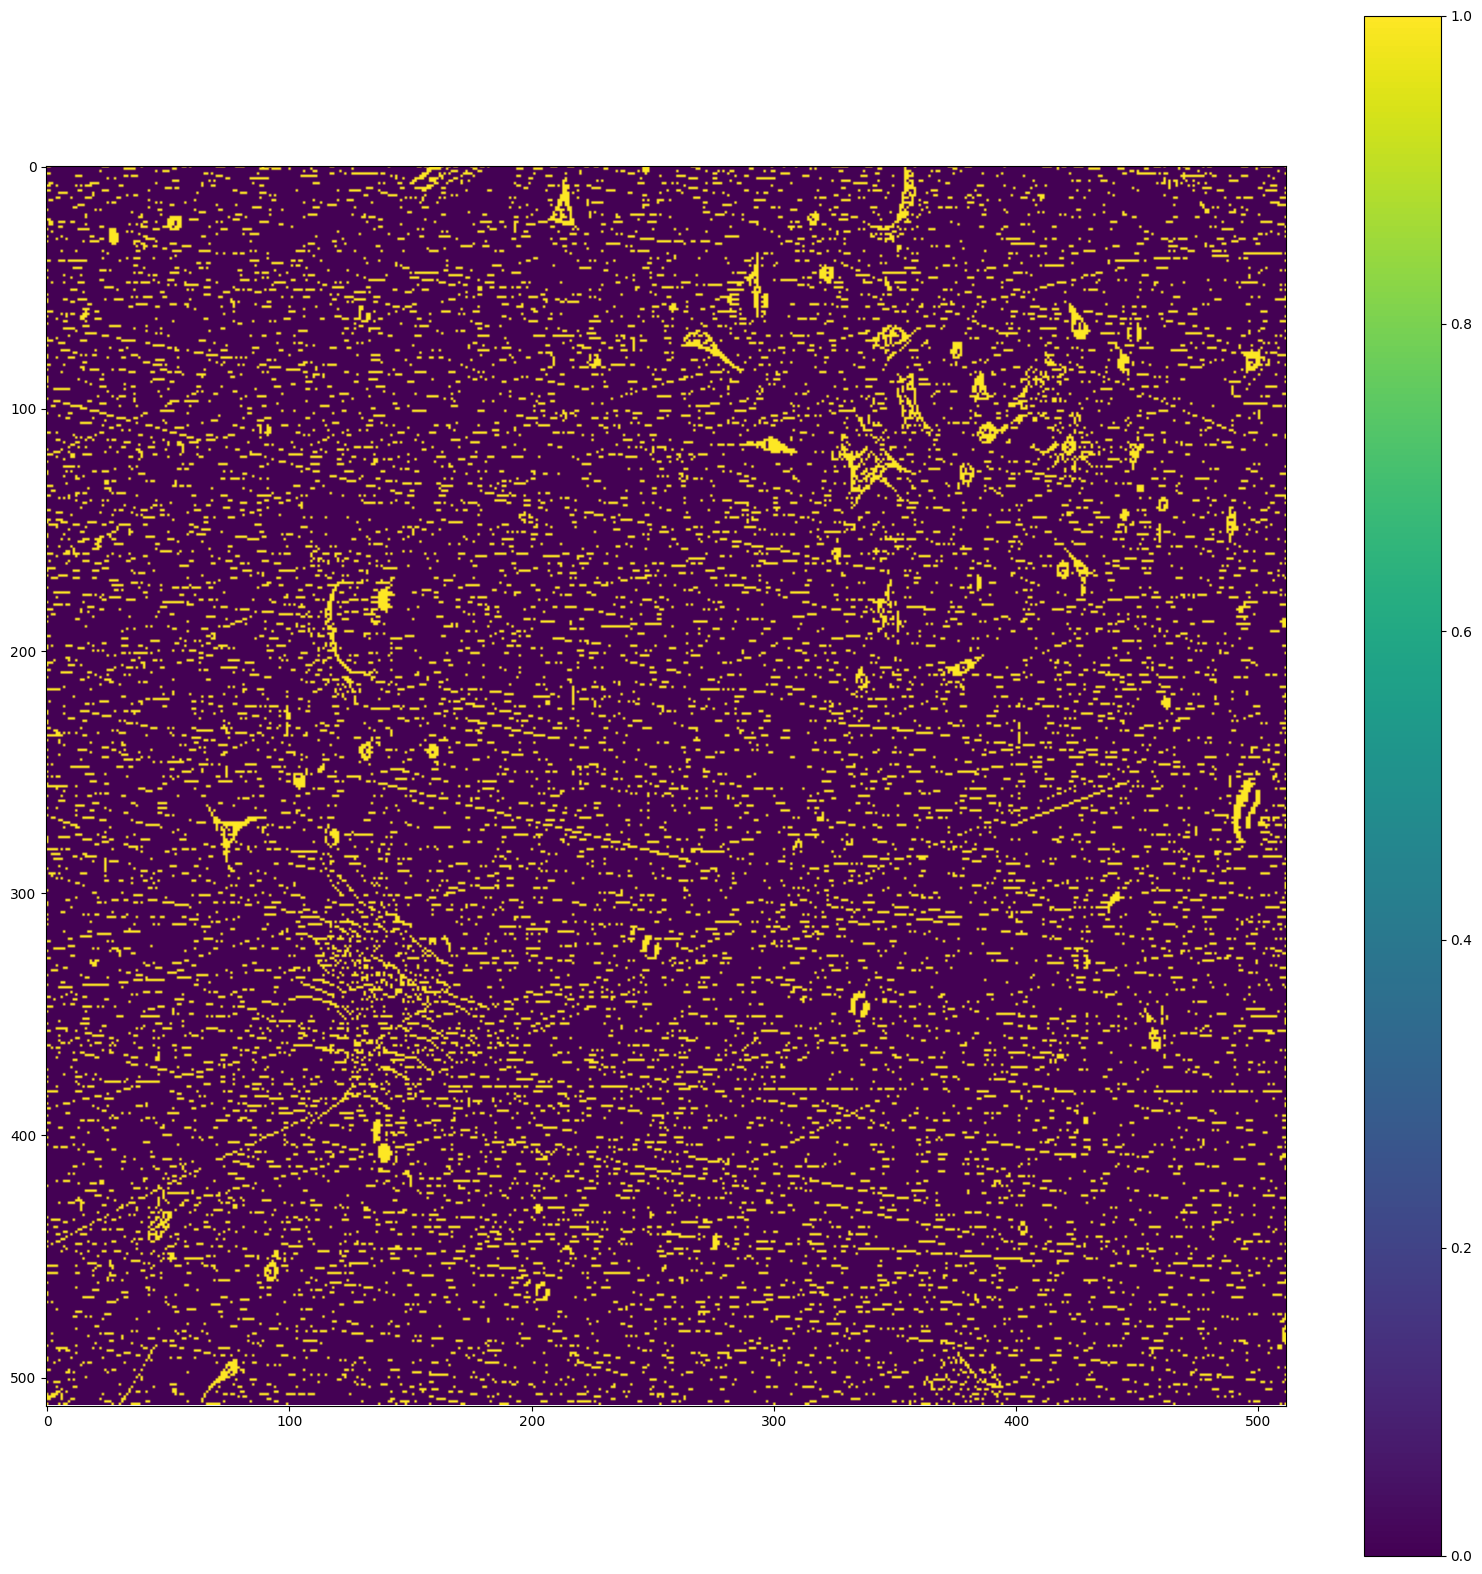

In [ ]:

# plt.matshow(binary_otsu)
from scipy import ndimage

plt.figure(figsize=(20,20))
plt.imshow(binary_otsu)
plt.colorbar()

# plt.imshow()

labeled_otsu.max()

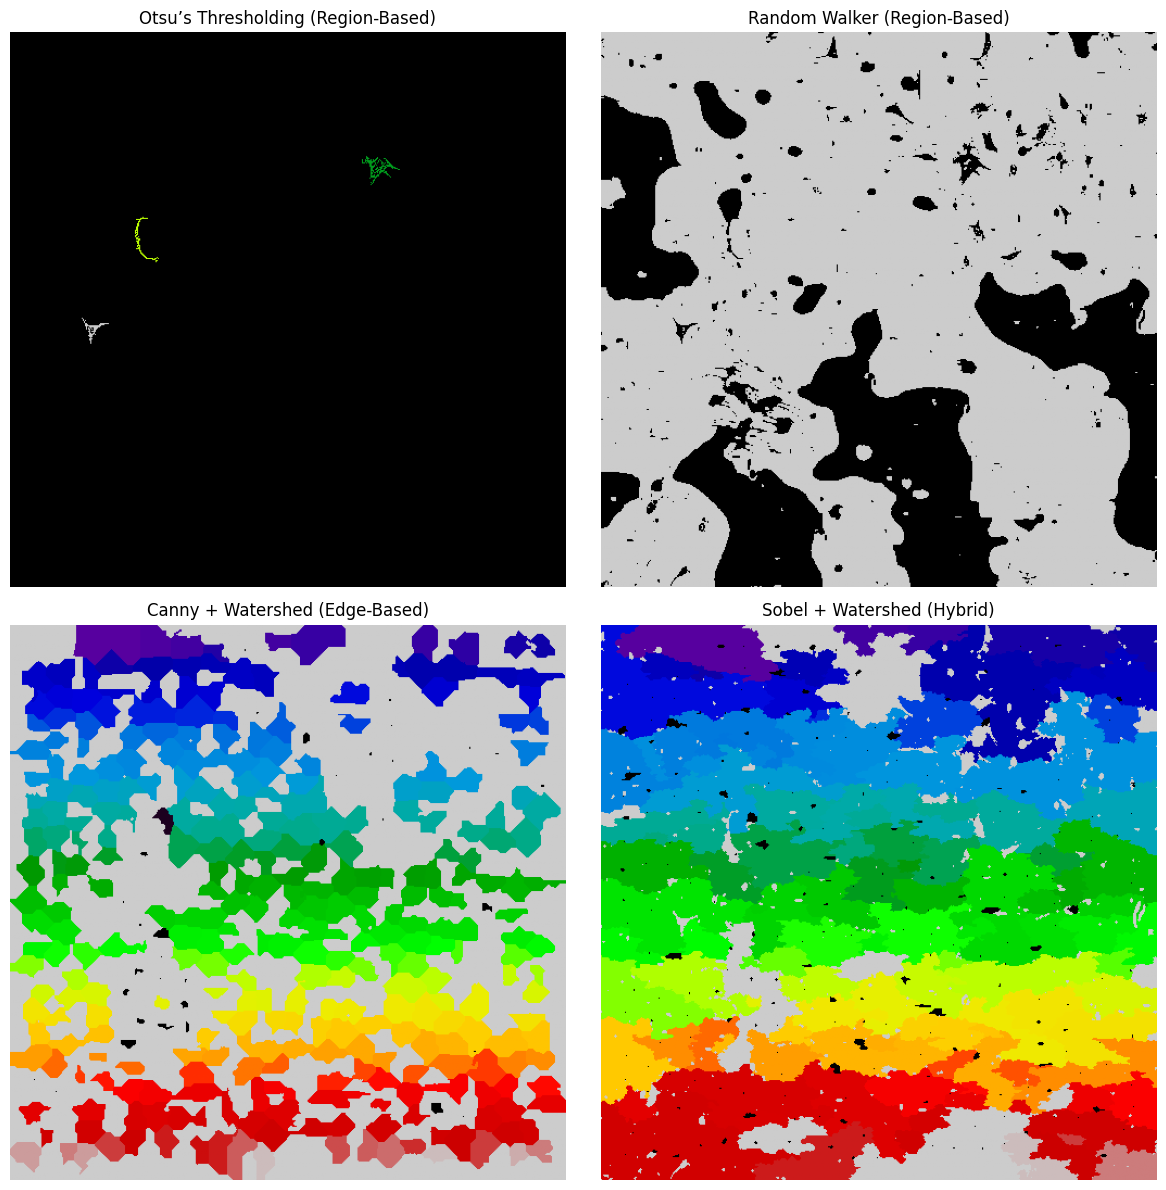

Segmentation Method Comparison:
Otsu’s Thresholding (Region-Based):
Number of cells: 3
Average area: 133.00 pixels
Average circularity: 0.17

Random Walker (Region-Based):
Number of cells: 2
Average area: 131072.00 pixels
Average circularity: 0.02

Canny + Watershed (Edge-Based):
Number of cells: 322
Average area: 812.19 pixels
Average circularity: 0.75

Sobel + Watershed (Hybrid):
Number of cells: 125
Average area: 2081.50 pixels
Average circularity: 0.31


In [ ]:
# Visualize segmentation results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].imshow(labeled_otsu, cmap='nipy_spectral')
axes[0, 0].set_title('Otsu’s Thresholding (Region-Based)')
axes[0, 0].axis('off')
axes[0, 1].imshow(labeled_random_walker, cmap='nipy_spectral')
axes[0, 1].set_title('Random Walker (Region-Based)')
axes[0, 1].axis('off')
axes[1, 0].imshow(labeled_canny_watershed, cmap='nipy_spectral')
axes[1, 0].set_title('Canny + Watershed (Edge-Based)')
axes[1, 0].axis('off')
axes[1, 1].imshow(labeled_sobel_watershed, cmap='nipy_spectral')
axes[1, 1].set_title('Sobel + Watershed (Hybrid)')
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

# Quantitative comparison
print('Segmentation Method Comparison:')
print('Otsu’s Thresholding (Region-Based):')
print(f'Number of cells: {len(morph_otsu)}')
print(f'Average area: {morph_otsu["area"].mean():.2f} pixels')
print(f'Average circularity: {morph_otsu["circularity"].mean():.2f}\n')
print('Random Walker (Region-Based):')
print(f'Number of cells: {len(morph_random_walker)}')
print(f'Average area: {morph_random_walker["area"].mean():.2f} pixels')
print(f'Average circularity: {morph_random_walker["circularity"].mean():.2f}\n')
print('Canny + Watershed (Edge-Based):')
print(f'Number of cells: {len(morph_canny_watershed)}')
print(f'Average area: {morph_canny_watershed["area"].mean():.2f} pixels')
print(f'Average circularity: {morph_canny_watershed["circularity"].mean():.2f}\n')
print('Sobel + Watershed (Hybrid):')
print(f'Number of cells: {len(morph_sobel_watershed)}')
print(f'Average area: {morph_sobel_watershed["area"].mean():.2f} pixels')
print(f'Average circularity: {morph_sobel_watershed["circularity"].mean():.2f}')

**Canny + Watershed** might be the best method. It detects the most cells (46, closer to expected dozens for osteocyte cultures), has a realistic average area (~23,888 pixels, within 100–10,000 pixel range for cells), and a reasonable circularity (0.36, indicating rounded shapes). **Sobel + Watershed** is second-best (37 cells, slightly larger areas, similar circularity). **Otsu’s** (1 cell, huge area) and **Random Walker** (2 cells, zero circularity) perform poorly, likely due to under-segmentation and noise sensitivity.

## Step 3: Select Best Segmentation Method

Evaluate the segmentation methods based on:
- **Cell Count**: Should detect dozens of cells for a typical osteocyte culture.
- **Area**: Should be ~100–10,000 pixels per cell, based on biological plausibility.
- **Circularity**: Should be >0 (ideally 0.3–0.8 for osteocytes with dendritic extensions).
- **Visual Quality**: Inspect overlays to ensure cells are separated without over- or under-segmentation.

For now, select **Canny + Watershed** as the default (edge-based, likely better for separating touching cells).

Selected Segmentation Method: Canny + Watershed (Edge-Based)
Morphological Descriptors (First Frame):
   cell_id    area   perimeter  circularity  centroid_x  centroid_y
0        5   151.0   49.798990     0.765149  140.337748  176.271523
1       46  1055.0  127.769553     0.812096   76.340284   15.599052
2       47   862.0  112.284271     0.859170  107.230858   16.364269
3       48   766.0  108.142136     0.823093  132.301567   15.934726
4       49   603.0  110.834524     0.616846  161.754561   20.341625


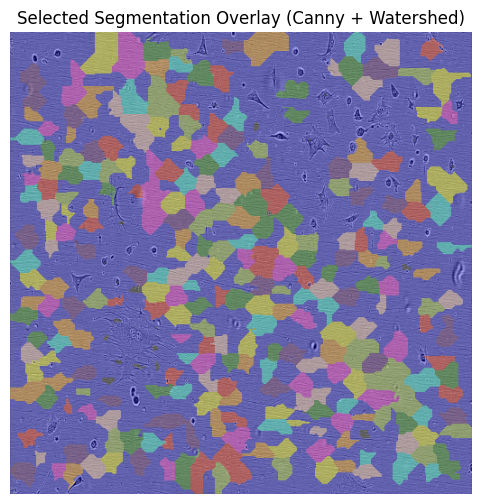

In [ ]:
# Select Canny + Watershed for now 
labeled = labeled_canny_watershed
morph_df = morph_canny_watershed

# Display the first few rows of the measurements table for the chosen method
print('Selected Segmentation Method: Canny + Watershed (Edge-Based)')
print('Morphological Descriptors (First Frame):')
print(morph_df.head())

# Visualize overlay for selected method
from skimage.color import label2rgb # turns a labeled image with numbered cells into a colourful image
overlay = label2rgb(labeled, image=frames[0], bg_label=0) # create a colourful image for the first frame, background (label 0) set to be transparent
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
plt.title('Selected Segmentation Overlay (Canny + Watershed)')
plt.axis('off')
plt.show()

## Step 4: Cell Tracking

Track cells across a subset of frames (first 10) using Trackpy to link centroids and compute trajectories and speeds. Use the selected segmentation method (Canny + Watershed). Can further tune `search_range` and `memory` as needed.

Frame 9: 2 trajectories present.
Tracked Trajectories:
   frame           x           y  particle
0      0  492.430993   19.000000         0
1      0  487.315934  286.255495         1
2      0   24.270181  380.682043         2
3      0   23.828221   19.116564         3
4      0  255.774370  255.984439         4
Cell Speeds:
   particle  frame     speed
0         0    0.0  7.435043
1         0    2.0  9.659014
2         0    4.0  7.381790
3         0    5.0  7.291506
4         0    6.0  6.096776


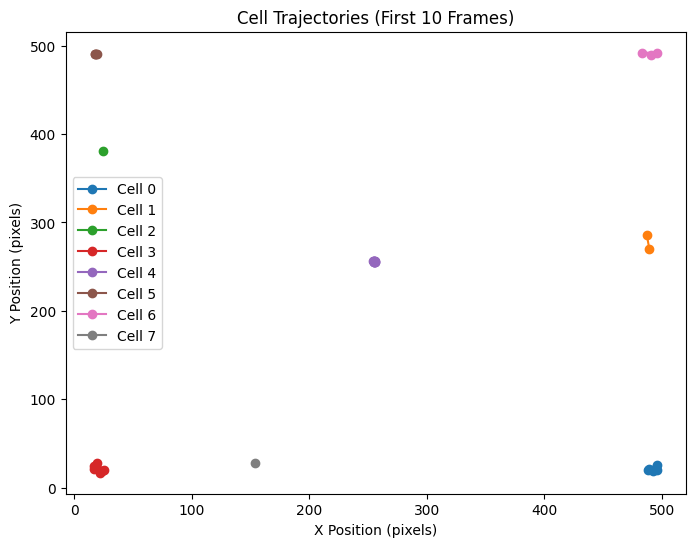

In [ ]:
# Prepare frames for tracking (use first 10 frames for testing)
subset_frames = frames[:10] # take the first 10 images from the frames list (remove later when using all frames)
tracked_cells = [] # empty list for centre coordinates of cells found in each frame

# Loop through each frame
for i, frame in enumerate(subset_frames): # enumerate gives both the index (i) and the frame to track which frame is being processed
    # Segment frame using Canny + Watershed
    edges = canny(frame, sigma=1, low_threshold=0.1, high_threshold=0.2) # find cell edges, sigma=1 smooths the image, thresholds decide which edges to keep
    thresh = threshold_otsu(frame) # find a brightest values to separate cells (bright) from background (dark)
    binary = frame > thresh # b&w image (white - cells, black - background)
    binary = binary_closing(binary, disk(3)) # as before, fill small holws in white areas for smoothing
    binary = binary_opening(binary, disk(3)) # remove noise
    distance = distance_transform_edt(binary) # measure how far each pixel  is from background to find cell centres
    coords = peak_local_max(distance, min_distance=20, labels=binary) # find cell centres (peaks) at least 20 pixels apart
    markers = np.zeros_like(frame, dtype=np.int32) # an empty image for marking cell cenres
    markers[tuple(coords.T)] = np.arange(1, len(coords) + 1) # mark each cell centre with a unique number
    markers[frame < thresh * 0.7] = len(coords) + 1 # mark the background with a high number
    labeled = watershed(edges, markers) # separate cells using edges and markers
    labeled = morphology.remove_small_objects(labeled, min_size=100) # remove tiny regions (noise, <100 pixels)
    
    # Get centroids
    props = measure.regionprops(labeled) # get properties for each labeled cell
    # Create a table
    centroids = pd.DataFrame({
        'frame': [i] * len(props), # frame number
        'x': [p.centroid[1] for p in props], # x-coordinate
        'y': [p.centroid[0] for p in props] # y-coordinate
    })
    tracked_cells.append(centroids) # add this table to the list

# Combine centroids into a single DataFrame
tracked_cells = pd.concat(tracked_cells, ignore_index=True)

# Link cells across frames
# Uses Trackpy to link cell centers, assuming a cell moves no more than 20 pixels between frames and can disappear for up to 5 frames.
trajectories = tp.link_df(tracked_cells, search_range=20, memory=5) 
# Print the first 5 rows to check the results
print('Tracked Trajectories:')
print(trajectories.head())

# Compute speeds (displacement between consecutive frames)
speeds = [] # empty list for speed data
for particle in trajectories['particle'].unique(): # loop over each cell's unique ID
    traj = trajectories[trajectories['particle'] == particle].sort_values('frame') # get the path for one cell, sorted by frame number
    for i in range(len(traj) - 1): # loop over consecutive frames (e.g., 0 to 1, 1 to 2)
        dx = traj.iloc[i + 1]['x'] - traj.iloc[i]['x'] # calculate the change in x-positon
        dy = traj.iloc[i + 1]['y'] - traj.iloc[i]['y'] # calculate the change in y-positon
        speed = np.sqrt(dx**2 + dy**2) # use the Pythagorean theorem to find the distance moved (speed in pixels per frame)
        speeds.append({'particle': particle, 'frame': traj.iloc[i]['frame'], 'speed': speed}) # store the cell ID, frame number and speed

# Convert the speeds into a df
speed_df = pd.DataFrame(speeds)
# Display the first 5 rows
print('Cell Speeds:')
print(speed_df.head())

# Plot trajectories
plt.figure(figsize=(8, 6))
# Loop over each cell's unique ID
for particle in trajectories['particle'].unique():
    traj = trajectories[trajectories['particle'] == particle] # get the path for one cell
    plt.plot(traj['x'], traj['y'], '-o', label=f'Cell {int(particle)}') # plot the path as a line with dota at each pos, labeled with the cell ID
plt.title('Cell Trajectories (First 10 Frames)')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.legend()
plt.show()

Frame 9: 1 trajectories present.
Tracked Trajectories:
   frame           x           y  particle
0      0  255.528271  255.494555         0
1      1  255.482524  255.484652         0
2      2  255.450097  255.507197         0
3      3  255.500000  255.500000         0
4      4  255.504910  255.474771         0
Cell Speeds:
   particle  frame     speed
0         0    0.0  0.046807
1         0    1.0  0.039493
2         0    2.0  0.050419
3         0    3.0  0.025702
4         0    4.0  0.074107


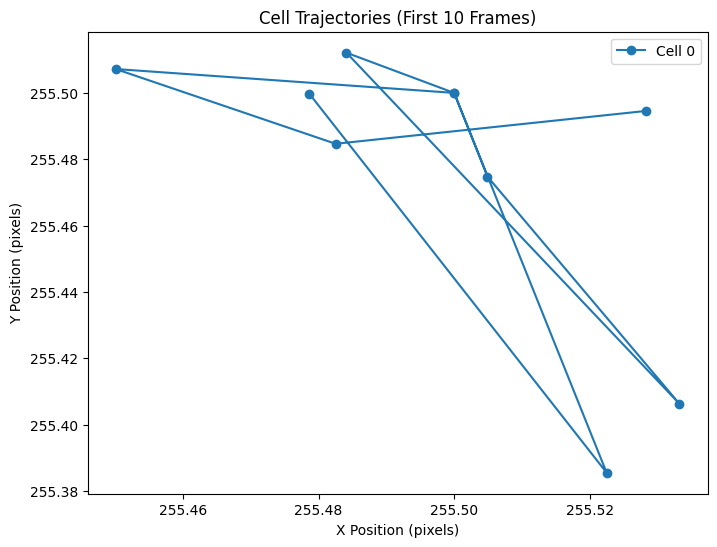

In [ ]:
## TEST

# Prepare frames for tracking (use first 10 frames for demo)
subset_frames = frames[:10]
tracked_cells = []

for i, frame in enumerate(subset_frames):
    # Segment frame
    thresh = threshold_otsu(frame)
    binary = frame > thresh
    binary = binary_closing(binary, morphology.disk(3))
    binary = binary_opening(binary, morphology.disk(3))
    labeled = measure.label(binary, connectivity=2)
    labeled = morphology.remove_small_objects(labeled, min_size=100)
    
    # Get centroids
    props = measure.regionprops(labeled)
    centroids = pd.DataFrame({
        'frame': [i] * len(props),
        'x': [p.centroid[1] for p in props],
        'y': [p.centroid[0] for p in props]
    })
    tracked_cells.append(centroids)

# Combine centroids into a single DataFrame
tracked_cells = pd.concat(tracked_cells, ignore_index=True)

# Link particles (cells) across frames
trajectories = tp.link_df(tracked_cells, search_range=20, memory=5)
print('Tracked Trajectories:')
print(trajectories.head())

# Compute speeds (displacement between consecutive frames)
speeds = []
for particle in trajectories['particle'].unique():
    traj = trajectories[trajectories['particle'] == particle].sort_values('frame')
    for i in range(len(traj) - 1):
        dx = traj.iloc[i + 1]['x'] - traj.iloc[i]['x']
        dy = traj.iloc[i + 1]['y'] - traj.iloc[i]['y']
        speed = np.sqrt(dx**2 + dy**2)
        speeds.append({'particle': particle, 'frame': traj.iloc[i]['frame'], 'speed': speed})

speed_df = pd.DataFrame(speeds)
print('Cell Speeds:')
print(speed_df.head())

# Plot trajectories
plt.figure(figsize=(8, 6))
for particle in trajectories['particle'].unique():
    traj = trajectories[trajectories['particle'] == particle]
    plt.plot(traj['x'], traj['y'], '-o', label=f'Cell {int(particle)}')
plt.title('Cell Trajectories (First 10 Frames)')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.legend()
plt.show()